# Title: Predicting Risk of Heart Disease Using Classification #
Group 14:
Jackie Hagstrom,
Hannah Reyes,
Mikayla Ditosto,
Minal Nijhawan 

# Introduction #
The theme of our project is heart disease, and we will be utilizing the data set sourced from the UC Irvine Machine Learning Repository. This data encompasses information from four distinct databases: Cleveland, Hungary, Switzerland, and VA Long Beach. Our study will concentrate on the Cleveland data set. This dataset classifies the presence of heart disease in a patient on a scale of 0-4 (0 implying the absence of risk, and 4 indicating the greatest presence).

Through this project, we are trying to answer the question: What variables can be used to classify a person’s risk of heart disease in Cleveland? Given that the response variable, num, is categorical, we will be solving this as a classification problem. There are a total of 14 different variables provided in the data set that can help detect the level of risk of heart disease in a patient. Please see the bottom of this document for the variable meanings.

# Preliminary exploratory data analysis #

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [14]:
# data was downloaded 
set.seed(2023)
cleveland_data <- read_csv("https://raw.githubusercontent.com/mikayladitosto/dsci-100-2023s1-group-14/main/processed.cleveland.data", col_names = FALSE)
colnames(cleveland_data) <- c("age",
                              "sex",
                              "cp",
                              "trestbps",
                              "chol",
                              "fbs",
                              "restecg",
                              "thalach",
                              "exang",
                              "oldpeak",
                              "slope",
                              "ca",
                              "thal",
                              "num")
cleveland_data <- cleveland_data |>
    mutate(num = as_factor(num))
head(cleveland_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age sex cp trestbps chol fbs restecg thalach exang oldpeak slope ca  thal num
1 63  1   1  145      233  1   2       150     0     2.3     3     0.0 6.0  0  
2 67  1   4  160      286  0   2       108     1     1.5     2     3.0 3.0  2  
3 67  1   4  120      229  0   2       129     1     2.6     2     2.0 7.0  1  
4 37  1   3  130      250  0   0       187     0     3.5     3     0.0 3.0  0  
5 41  0   2  130      204  0   2       172     0     1.4     1     0.0 3.0  0  
6 56  1   2  120      236  0   0       178     0     0.8     1     0.0 3.0  0

We downloaded the Cleveland data set and uploaded it to GitHub through our shared repository. After this step, we copied the URL into R, and we were able to read it with the read_csv function. Demonstrating that the dataset can be read from the web into R. 

In [56]:
# removed N/A values from the dataset
cleveland_data <- cleveland_data |>
    filter(age != "?" &
           sex != "?" &
           cp != "?" &
           trestbps != "?" &
           chol != "?" &
           fbs != "?" &
           restecg != "?" &
           thalach != "?" &
           exang != "?" &
           oldpeak != "?" &
           slope != "?" &
           ca != "?" &
           thal != "?" )

cleveland_data <- cleveland_data |>
    mutate(ca = as.numeric(ca),
           thal = as.numeric(thal))

# split the data into training and testing splits
cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

In [57]:
num_obs <- nrow(cleveland_training)
cleveland_training |>
  group_by(num) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )

num count percentage
1 0   120   54.054054 
2 1    40   18.018018 
3 2    27   12.162162 
4 3    26   11.711712 
5 4     9    4.054054

This table shows us the number of observations in each category of heart disease. There is not an equal amount of people in each category, meaning our graphs can look disproportionate. During the classification analysis in our final project, we can make the classes proportionate by using class balancing to ensure the rarer classes are equally represented.

In [58]:
cleveland_mean <- cleveland_training |>
    group_by(num) |>
    summarise(mean_age = mean(age),
           mean_sex = mean(sex),
           mean_cp = mean(cp),
           mean_trestbps = mean(trestbps),
           mean_chol = mean(chol),
           mean_fbs = mean(fbs),
           mean_restecg = mean(restecg),
           mean_thalach = mean(thalach),
           mean_exang = mean(exang),
           mean_oldpeak = mean(oldpeak),
           mean_slope = mean(slope),
           mean_ca = mean(ca),
           mean_thal = mean(thal))
cleveland_mean

cleveland_sd <- cleveland_training |>
    group_by(num) |>
    summarise(sd_age = sd(age),
              sd_sex = sd(sex),
              sd_cp = sd(cp),
              sd_trestbps = sd(trestbps),
           sd_chol = sd(chol),
           sd_fbs = sd(fbs),
           sd_restecg = sd(restecg),
           sd_thalach = sd(thalach),
           sd_exang = sd(exang),
           sd_oldpeak = sd(oldpeak),
           sd_slope = sd(slope),
           sd_ca = sd(ca),
           sd_thal = sd(thal))
cleveland_sd

num mean_age mean_sex  mean_cp  mean_trestbps mean_chol mean_fbs 
1 0   52.17500 0.5500000 2.841667 129.1917      242.2417  0.1333333
2 1   54.92500 0.8500000 3.225000 134.1000      249.2500  0.0500000
3 2   58.14815 0.7777778 3.666667 135.0000      258.6296  0.2222222
4 3   55.92308 0.8461538 3.769231 134.9615      249.0769  0.1923077
5 4   58.77778 0.7777778 3.666667 138.0000      265.4444  0.1111111
  mean_restecg mean_thalach mean_exang mean_oldpeak mean_slope mean_ca  
1 0.8083333    158.9750     0.1416667  0.572500     1.375000   0.2916667
2 1.4000000    148.3750     0.3750000  0.982500     1.525000   0.7250000
3 0.9259259    135.5185     0.6296296  1.818519     1.888889   1.3333333
4 1.2692308    131.3846     0.6923077  2.126923     2.000000   1.4230769
5 1.6666667    140.1111     0.4444444  2.533333     2.000000   2.0000000
  mean_thal
1 3.633333 
2 5.325000 
3 6.037037 
4 6.384615 
5 6.000000

num sd_age    sd_sex    sd_cp     sd_trestbps sd_chol  sd_fbs    sd_restecg
1 0    9.699400 0.4995797 0.8887328 17.05419    48.53951 0.3413599 0.9813028 
2 1    8.052353 0.3616203 1.0974913 18.23184    43.39960 0.2207214 0.9281910 
3 2    6.706505 0.4236593 0.7337994 17.36486    53.82532 0.4236593 0.9971469 
4 3    7.646819 0.3679465 0.5144078 20.99806    46.61495 0.4019185 0.9615692 
5 4   10.651030 0.4409586 1.0000000 16.93369    72.10255 0.3333333 0.7071068 
  sd_thalach sd_exang  sd_oldpeak sd_slope  sd_ca     sd_thal 
1 18.61438   0.3501700 0.8181720  0.5806762 0.6403234 1.431538
2 22.07294   0.4902903 0.9726747  0.5057363 0.8469402 1.939964
3 18.33528   0.4921029 1.1269554  0.5063697 0.9607689 1.531251
4 21.64454   0.4706787 1.5885988  0.6324555 1.0265701 1.471786
5 21.81997   0.5270463 1.5620499  0.5000000 1.3228757 1.732051

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



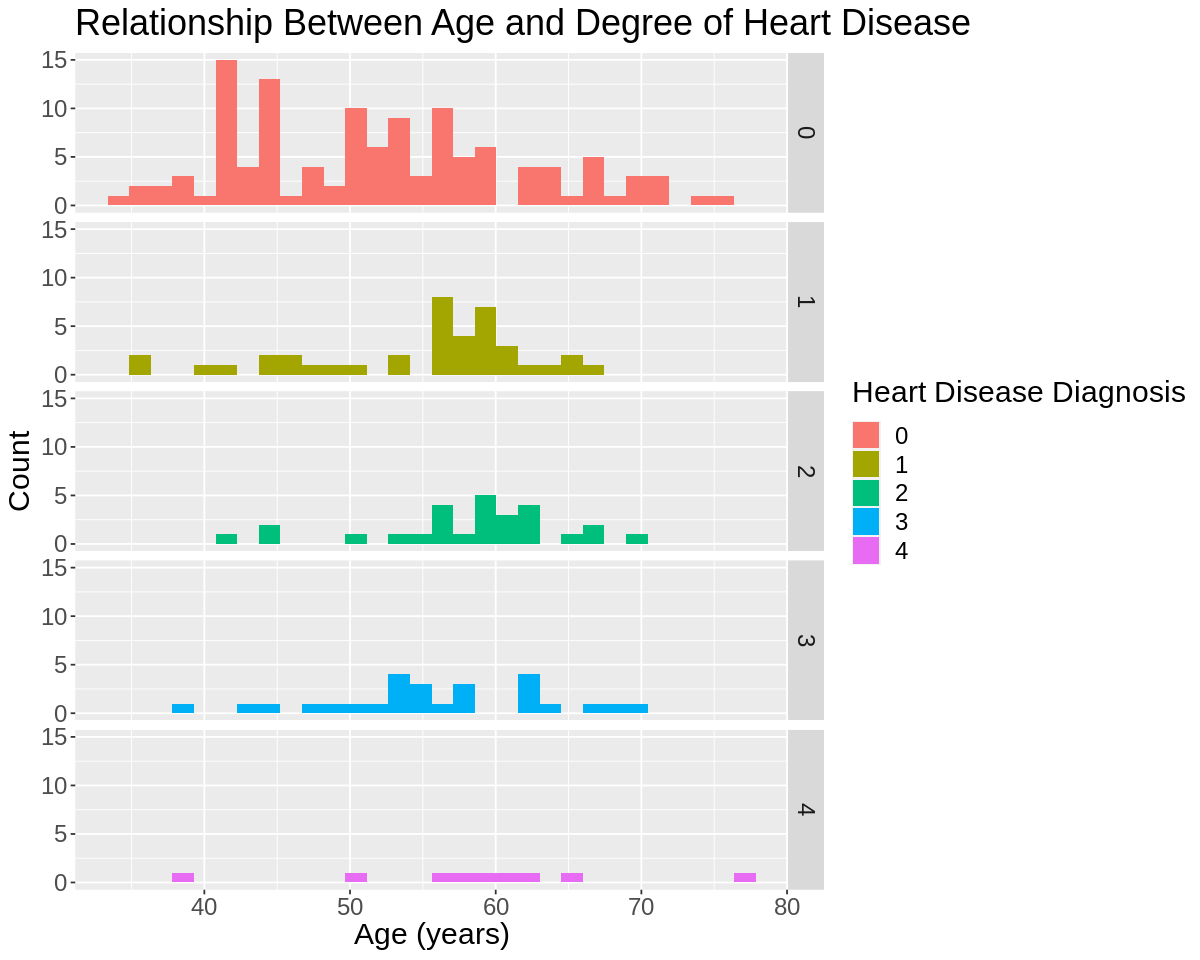

In [59]:
options(repr.plot.height = 8, repr.plot.width = 10)
age_hist <- ggplot(cleveland_training, aes(x = age, fill = num)) +
  geom_histogram(position = "identity") +
  facet_grid(rows = vars(num)) +
  labs(x = "Age (years)",
       y = "Count",
       fill = "Heart Disease Diagnosis") +
  ggtitle("Relationship Between Age and Degree of Heart Disease") +
  theme(text = element_text(size = 18))
age_hist

Based on the results from our histogram, it shows that there is no distinct relationship between age and num.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



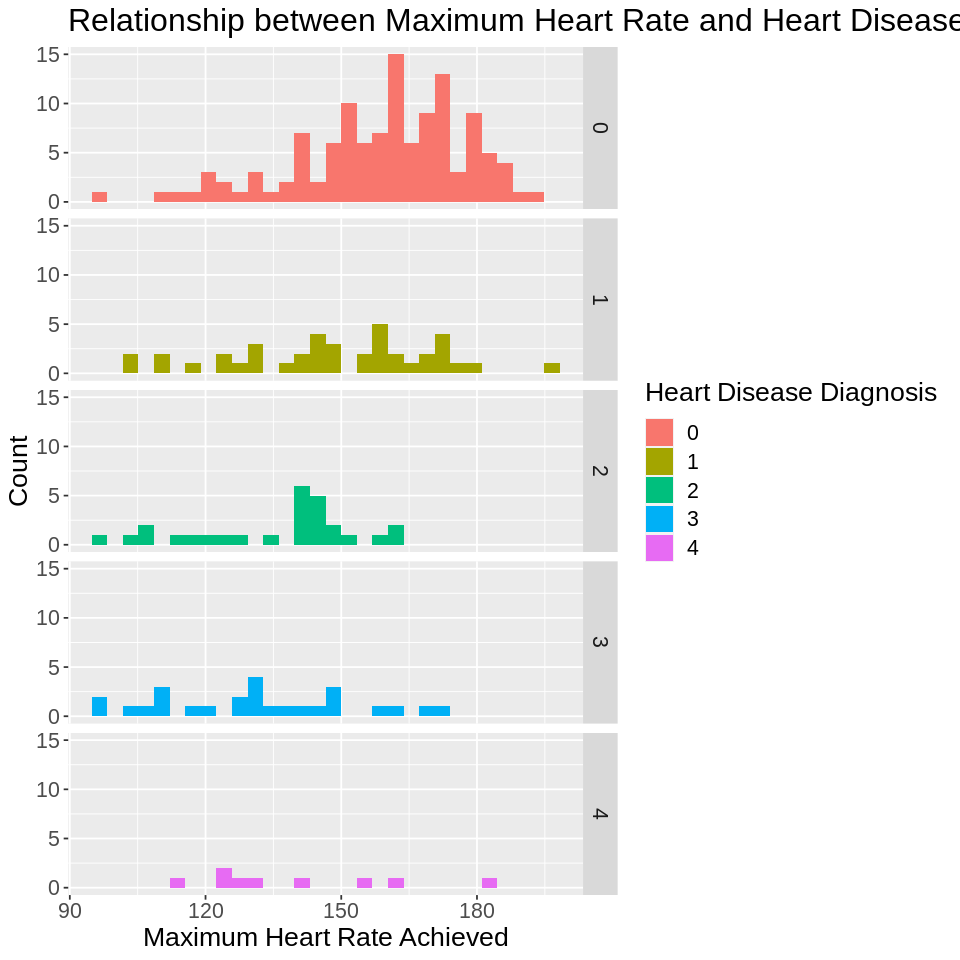

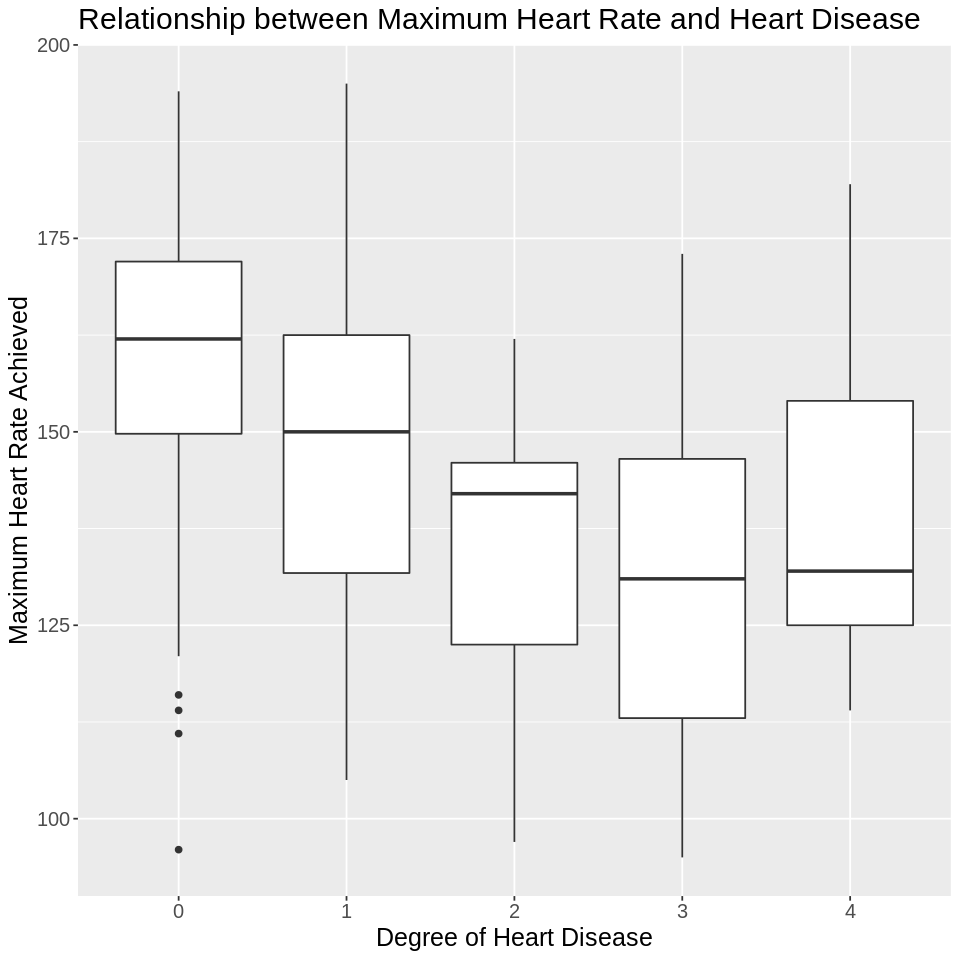

In [68]:
options(repr.plot.height = 8, repr.plot.width = 8)
thalach_plot <- cleveland_training |>
    ggplot(aes(x = thalach, fill = num)) +
    geom_histogram() +
    facet_grid(rows = vars(num)) +
    labs(x = "Maximum Heart Rate Achieved",
         y = "Count",
      fill = "Heart Disease Diagnosis") +
    theme(text = element_text(size = 16)) +
    ggtitle("Relationship between Maximum Heart Rate and Heart Disease")
thalach_plot

thalach_plot2 <- cleveland_training |>
    ggplot(aes(y = thalach, x = num)) +
    geom_boxplot() +
    labs(x = "Degree of Heart Disease",
         y = "Maximum Heart Rate Achieved") +
    theme(text = element_text(size = 15)) +
    ggtitle("Relationship between Maximum Heart Rate and Heart Disease")
thalach_plot2

? Explanation about max heart rate graph

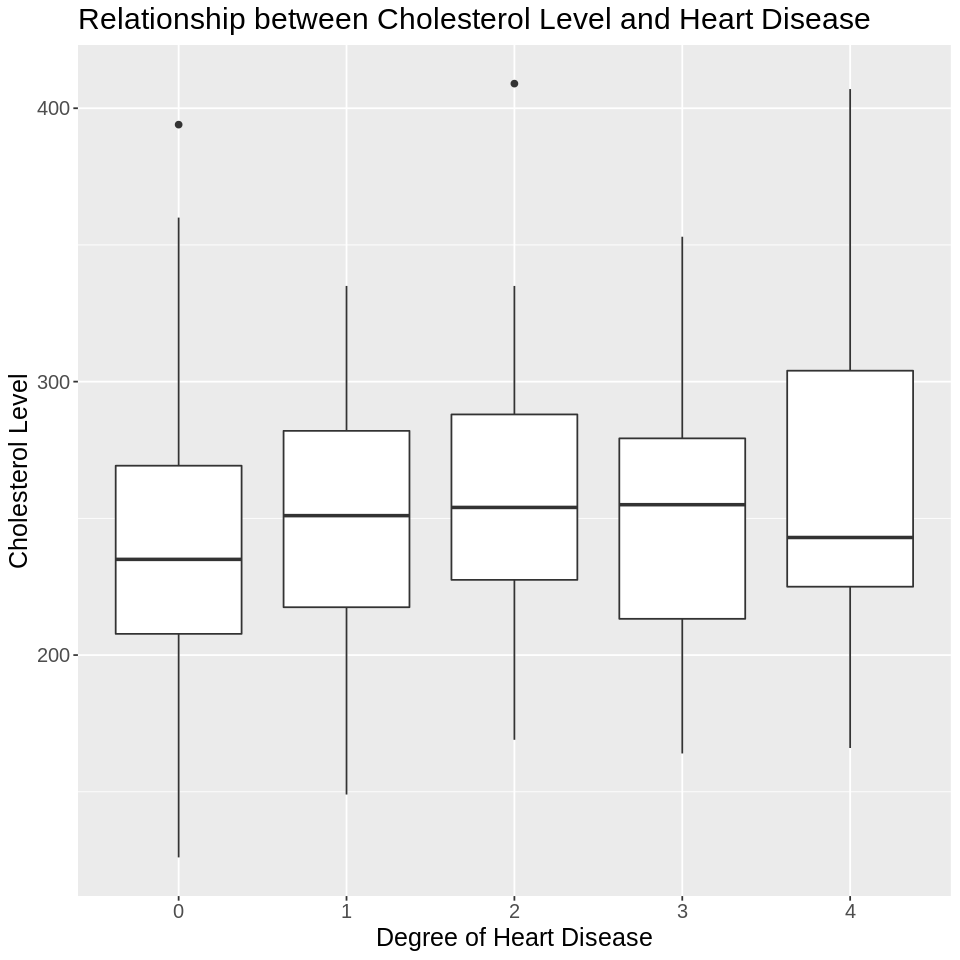

In [69]:
chol_plot <- cleveland_training |>
    ggplot(aes(y = chol, x = num)) +
    geom_boxplot() +
    labs(x = "Degree of Heart Disease",
         y = "Cholesterol Level") +
    theme(text = element_text(size = 15)) +
    ggtitle("Relationship between Cholesterol Level and Heart Disease")
chol_plot

? Explanation for chol plot

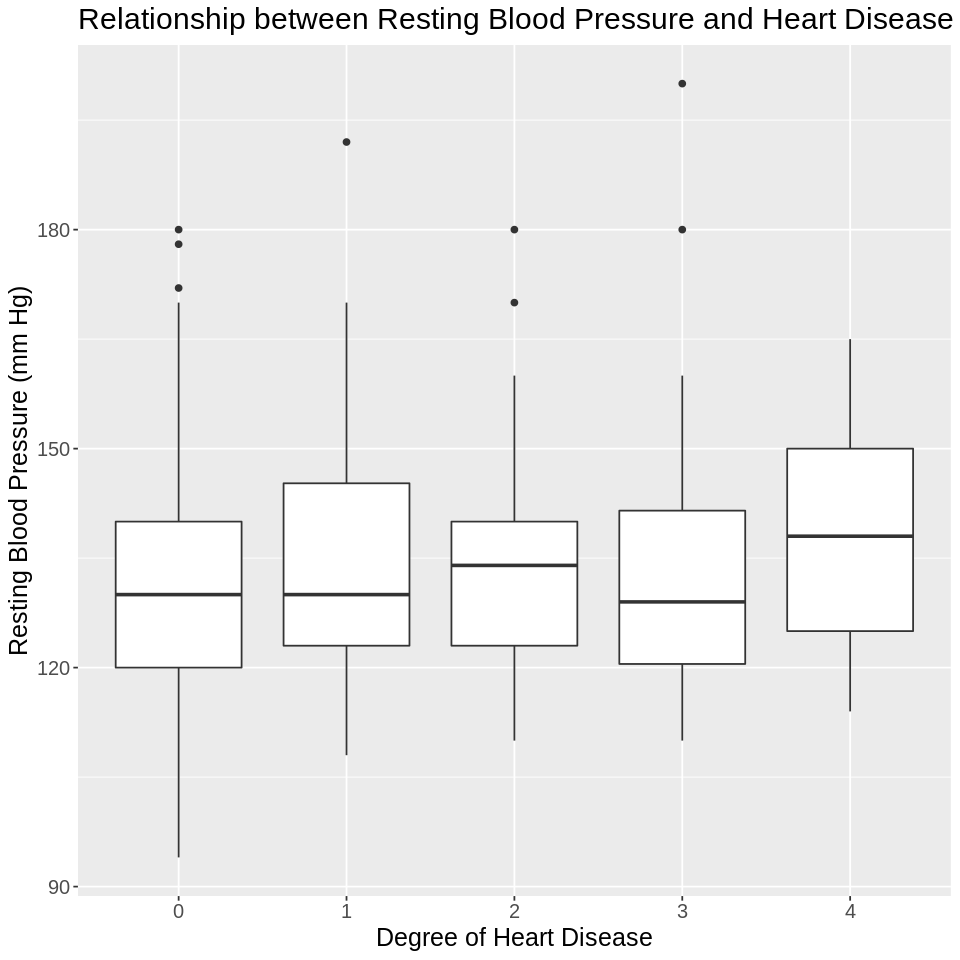

In [70]:
bp_plot <- cleveland_training |>
    ggplot(aes(y = trestbps, x = num)) +
    geom_boxplot() +
    labs(x = "Degree of Heart Disease",
         y = "Resting Blood Pressure (mm Hg)") +
    theme(text = element_text(size = 15)) +
    ggtitle("Relationship between Resting Blood Pressure and Heart Disease")
bp_plot

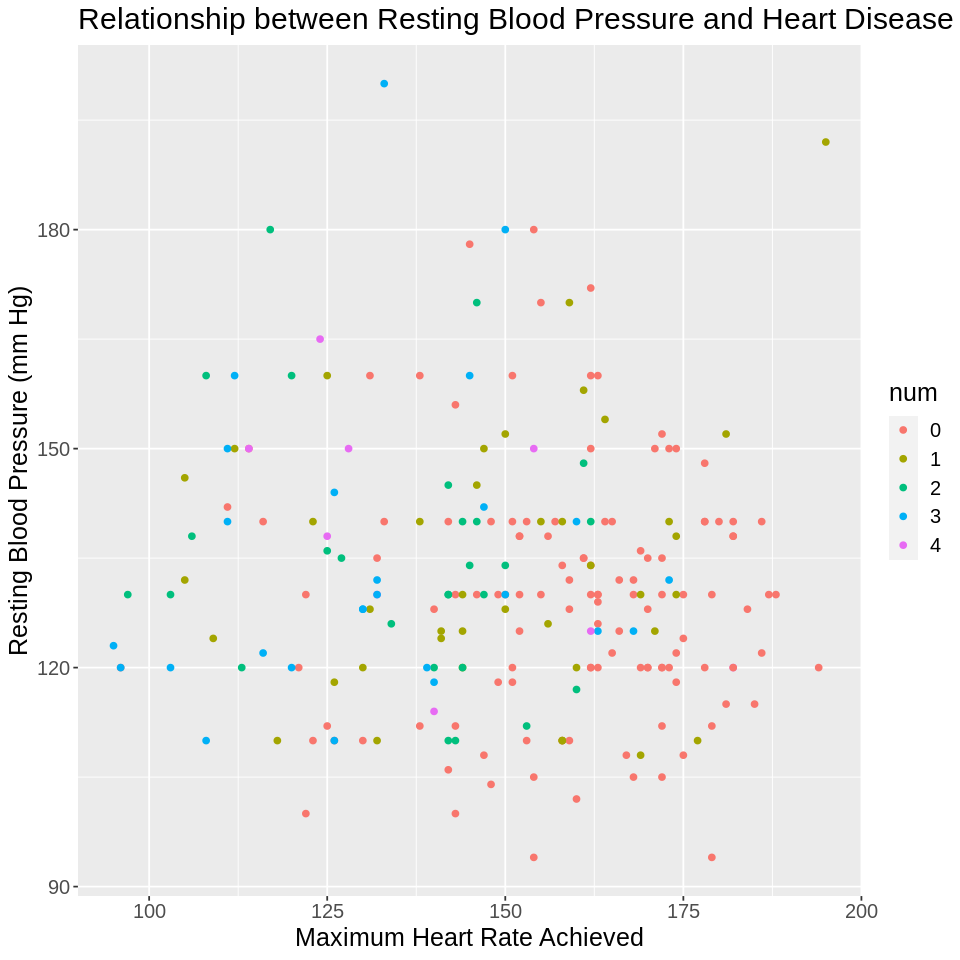

In [72]:
trestbps_thalach_plot <- cleveland_training |>
    ggplot(aes(y = trestbps, x = thalach, color = num)) +
    geom_point() +
    labs(x = "Maximum Heart Rate Achieved",
         y = "Resting Blood Pressure (mm Hg)") +
    theme(text = element_text(size = 15)) +
    ggtitle("Relationship between Resting Blood Pressure and Heart Disease")
trestbps_thalach_plot

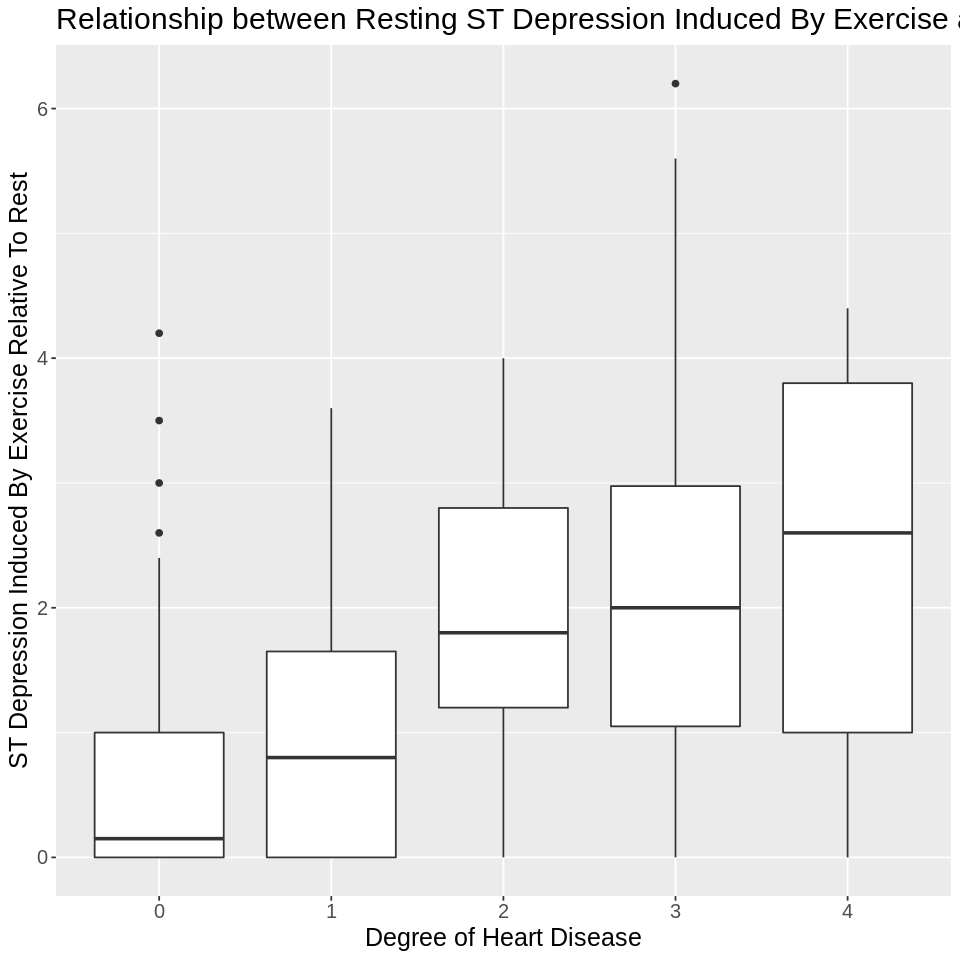

In [73]:
oldpeak_plot <- cleveland_training |>
    ggplot(aes(y = oldpeak, x = num)) +
    geom_boxplot() +
    labs(x = "Degree of Heart Disease",
         y = "ST Depression Induced By Exercise Relative To Rest") +
    theme(text = element_text(size = 15)) +
    ggtitle("Relationship between Resting ST Depression Induced By Exercise and Heart Disease")
oldpeak_plot

Relationship here???

# Expected outcomes and significance #
From our research and findings, we expect that lower maximum heart rate (thalach) is a possible indicator/association for heart disease. We hope that our findings can validate other papers. The impact of these findings could influence the population of Cleveland to change certain practices according to our analysis. Future research related to heart disease could go down different paths, such as nutrition or  different lifestyle habits or practices. For example,  focus on different foods that help reduce cholesterol levels, which could potentially reduce heart disease. 

# Variables #
 1. (age) -> age in years
2. (sex) -> sex (1 = male; 0 = female)  
3. (cp) -> cp: chest pain type
4. (trestbps) -> resting blood pressure (in mm Hg on admission to the 
        hospital)
5. (chol) -> serum cholesterol in mg/dl
6. (fbs) -> (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
7. (restecg) -> resting electrocardiographic results
8. (thalach) -> maximum heart rate achieved
9. (exang) -> exercise induced angina 1= yes, 0= no
10. (oldpeak) -> ST depression induced by exercise relative to rest
11. (slope) ->  the slope of the peak exercise ST segment
 Value 1: upsloping
Value 2: flat
Value 3: downsloping
12. (ca) -> number of major vessels (0-3) colored by flourosopy
13. (thal) -> 3= normal, 6= fixed defect, 7= reversible defect
14. (num) -> (the predicted attribute) diagnosis of heart disease
Value 0: < 50% diameter narrowing
Value 1: > 50% diameter narrowing (in any major vessel)
